In [0]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import lines

from ipywidgets import interact
import ipywidgets as widgets

from collections import deque
import math
import heapq

import time
import random
import bisect

# Exercício sobre busca gulosa e A*

Similar ao exercício anterior, queremos agora comparar busca através de algoritmos gulosos e através de A*.

## Importando classes e funções necessárias

In [0]:
def show_map(graph_data, node_colors = None):
    G = nx.Graph(graph_data['graph_dict'])
    node_colors = node_colors or graph_data['node_colors']
    node_positions = graph_data['node_positions']
    node_label_pos = graph_data['node_label_positions']
    edge_weights= graph_data['edge_weights']
    
    # set the size of the plot
    plt.figure(figsize=(18,13))
    # draw the graph (both nodes and edges) with locations from romania_locations
    nx.draw(G, pos={k: node_positions[k] for k in G.nodes()},
            node_color=[node_colors[node] for node in G.nodes()], linewidths=0.3, edgecolors='k')

    # draw labels for nodes
    node_label_handles = nx.draw_networkx_labels(G, pos=node_label_pos, font_size=14)
    
    # add a white bounding box behind the node labels
    [label.set_bbox(dict(facecolor='white', edgecolor='none')) for label in node_label_handles.values()]

    # add edge lables to the graph
    nx.draw_networkx_edge_labels(G, pos=node_positions, edge_labels=edge_weights, font_size=14)
    
    # add a legend
    white_circle = lines.Line2D([], [], color="white", marker='o', markersize=15, markerfacecolor="white")
    orange_circle = lines.Line2D([], [], color="orange", marker='o', markersize=15, markerfacecolor="orange")
    red_circle = lines.Line2D([], [], color="red", marker='o', markersize=15, markerfacecolor="red")
    gray_circle = lines.Line2D([], [], color="gray", marker='o', markersize=15, markerfacecolor="gray")
    green_circle = lines.Line2D([], [], color="green", marker='o', markersize=15, markerfacecolor="green")
    plt.legend((white_circle, orange_circle, red_circle, gray_circle, green_circle),
               ('Un-explored', 'Frontier', 'Currently Exploring', 'Explored', 'Final Solution'),
               numpoints=1, prop={'size':16}, loc=(.8,.75))
    
    # show the plot. No need to use in notebooks. nx.draw will show the graph itself.
    plt.show()

In [0]:
class Problem(object):

    """The abstract class for a formal problem. You should subclass
    this and implement the methods actions and result, and possibly
    __init__, goal_test, and path_cost. Then you will create instances
    of your subclass and solve them with the various search functions."""

    def __init__(self, initial, goal=None):
        """The constructor specifies the initial state, and possibly a goal
        state, if there is a unique goal. Your subclass's constructor can add
        other arguments."""
        self.initial = initial
        self.goal = goal

    def actions(self, state):
        """Return the actions that can be executed in the given
        state. The result would typically be a list, but if there are
        many actions, consider yielding them one at a time in an
        iterator, rather than building them all at once."""
        raise NotImplementedError

    def result(self, state, action):
        """Return the state that results from executing the given
        action in the given state. The action must be one of
        self.actions(state)."""
        raise NotImplementedError

    def goal_test(self, state):
        """Return True if the state is a goal. The default method compares the
        state to self.goal or checks for state in self.goal if it is a
        list, as specified in the constructor. Override this method if
        checking against a single self.goal is not enough."""
        if isinstance(self.goal, list):
            return is_in(state, self.goal)
        else:
            return state == self.goal

    def path_cost(self, c, state1, action, state2):
        """Return the cost of a solution path that arrives at state2 from
        state1 via action, assuming cost c to get up to state1. If the problem
        is such that the path doesn't matter, this function will only look at
        state2.  If the path does matter, it will consider c and maybe state1
        and action. The default method costs 1 for every step in the path."""
        return c + 1

    def value(self, state):
        """For optimization problems, each state has a value.  Hill-climbing
        and related algorithms try to maximize this value."""
        raise NotImplementedError

class GraphProblem(Problem):

    """The problem of searching a graph from one node to another."""

    def __init__(self, initial, goal, graph):
        Problem.__init__(self, initial, goal)
        self.graph = graph

    def actions(self, A):
        """The actions at a graph node are just its neighbors."""
        return list(self.graph.get(A).keys())

    def result(self, state, action):
        """The result of going to a neighbor is just that neighbor."""
        return action

    def path_cost(self, cost_so_far, A, action, B):
        return cost_so_far + (self.graph.get(A, B) or infinity)

    def find_min_edge(self):
        """Find minimum value of edges."""
        m = infinity
        for d in self.graph.graph_dict.values():
            local_min = min(d.values())
            m = min(m, local_min)

        return m

    def h(self, node):
        """h function is straight-line distance from a node's state to goal."""
        locs = getattr(self.graph, 'locations', None)
        if locs:
            if type(node) is str:
                return int(distance(locs[node], locs[self.goal]))

            return int(distance(locs[node.state], locs[self.goal]))
        else:
            return infinity

In [0]:
class Node:

    """A node in a search tree. Contains a pointer to the parent (the node
    that this is a successor of) and to the actual state for this node. Note
    that if a state is arrived at by two paths, then there are two nodes with
    the same state.  Also includes the action that got us to this state, and
    the total path_cost (also known as g) to reach the node.  Other functions
    may add an f and h value; see best_first_graph_search and astar_search for
    an explanation of how the f and h values are handled. You will not need to
    subclass this class."""

    def __init__(self, state, parent=None, action=None, path_cost=0):
        """Create a search tree Node, derived from a parent by an action."""
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = 0
        if parent:
            self.depth = parent.depth + 1

    def __repr__(self):
        return "<Node {}>".format(self.state)

    def __lt__(self, node):
        return self.state < node.state

    def expand(self, problem):
        """List the nodes reachable in one step from this node."""
        return [self.child_node(problem, action)
                for action in problem.actions(self.state)]

    def child_node(self, problem, action):
        """[Figure 3.10]"""
        next_state = problem.result(self.state, action)
        next_node = Node(next_state, self, action,
                    problem.path_cost(self.path_cost, self.state,
                                      action, next_state))
        return next_node
    
    def solution(self):
        """Return the sequence of actions to go from the root to this node."""
        return [node.action for node in self.path()[1:]]

    def path(self):
        """Return a list of nodes forming the path from the root to this node."""
        node, path_back = self, []
        while node:
            path_back.append(node)
            node = node.parent
        return list(reversed(path_back))

    # We want for a queue of nodes in breadth_first_graph_search or
    # astar_search to have no duplicated states, so we treat nodes
    # with the same state as equal. [Problem: this may not be what you
    # want in other contexts.]

    def __eq__(self, other):
        return isinstance(other, Node) and self.state == other.state

    def __hash__(self):
        return hash(self.state)

class Graph:

    """A graph connects nodes (vertices) by edges (links).  Each edge can also
    have a length associated with it.  The constructor call is something like:
        g = Graph({'A': {'B': 1, 'C': 2})
    this makes a graph with 3 nodes, A, B, and C, with an edge of length 1 from
    A to B,  and an edge of length 2 from A to C.  You can also do:
        g = Graph({'A': {'B': 1, 'C': 2}, directed=False)
    This makes an undirected graph, so inverse links are also added. The graph
    stays undirected; if you add more links with g.connect('B', 'C', 3), then
    inverse link is also added.  You can use g.nodes() to get a list of nodes,
    g.get('A') to get a dict of links out of A, and g.get('A', 'B') to get the
    length of the link from A to B.  'Lengths' can actually be any object at
    all, and nodes can be any hashable object."""

    def __init__(self, graph_dict=None, directed=True):
        self.graph_dict = graph_dict or {}
        self.directed = directed
        if not directed:
            self.make_undirected()

    def make_undirected(self):
        """Make a digraph into an undirected graph by adding symmetric edges."""
        for a in list(self.graph_dict.keys()):
            for (b, dist) in self.graph_dict[a].items():
                self.connect1(b, a, dist)

    def connect(self, A, B, distance=1):
        """Add a link from A and B of given distance, and also add the inverse
        link if the graph is undirected."""
        self.connect1(A, B, distance)
        if not self.directed:
            self.connect1(B, A, distance)

    def connect1(self, A, B, distance):
        """Add a link from A to B of given distance, in one direction only."""
        self.graph_dict.setdefault(A, {})[B] = distance

    def get(self, a, b=None):
        """Return a link distance or a dict of {node: distance} entries.
        .get(a,b) returns the distance or None;
        .get(a) returns a dict of {node: distance} entries, possibly {}."""
        links = self.graph_dict.setdefault(a, {})
        if b is None:
            return links
        else:
            return links.get(b)

    def nodes(self):
        """Return a list of nodes in the graph."""
        s1 = set([k for k in self.graph_dict.keys()])
        s2 = set([k2 for v in self.graph_dict.values() for k2, v2 in v.items()])
        nodes = s1.union(s2)
        return list(nodes)        
        
def UndirectedGraph(graph_dict=None):
    """Build a Graph where every edge (including future ones) goes both ways."""
    return Graph(graph_dict = graph_dict, directed=False)

In [0]:
class PriorityQueue:
    """A Queue in which the minimum (or maximum) element (as determined by f and
    order) is returned first.
    If order is 'min', the item with minimum f(x) is
    returned first; if order is 'max', then it is the item with maximum f(x).
    Also supports dict-like lookup."""

    def __init__(self, order='min', f=lambda x: x):
        self.heap = []

        if order == 'min':
            self.f = f
        elif order == 'max':  # now item with max f(x)
            self.f = lambda x: -f(x)  # will be popped first
        else:
            raise ValueError("order must be either 'min' or 'max'.")

    def append(self, item):
        """Insert item at its correct position."""
        heapq.heappush(self.heap, (self.f(item), item))

    def extend(self, items):
        """Insert each item in items at its correct position."""
        for item in items:
            self.append(item)

    def pop(self):
        """Pop and return the item (with min or max f(x) value)
        depending on the order."""
        if self.heap:
            return heapq.heappop(self.heap)[1]
        else:
            raise Exception('Trying to pop from empty PriorityQueue.')

    def __len__(self):
        """Return current capacity of PriorityQueue."""
        return len(self.heap)

    def __contains__(self, key):
        """Return True if the key is in PriorityQueue."""
        return any([item == key for _, item in self.heap])
    
    def get(self, key):
        """Returns the first value associated with key in PriorityQueue.
        Raises KeyError if key is not present."""
        for value, item in self.heap:
            if item == key:
                return item
        raise KeyError(str(key) + " is not in the priority queue")

    def __getitem__(self, key):
        """Returns the first value associated with key in PriorityQueue.
        Raises KeyError if key is not present."""
        for value, item in self.heap:
            if item == key:
                return value
        raise KeyError(str(key) + " is not in the priority queue")

    def __delitem__(self, key):
        """Delete the first occurrence of key."""
        try:
            del self.heap[[item == key for _, item in self.heap].index(True)]
        except ValueError:
            raise KeyError(str(key) + " is not in the priority queue")
        heapq.heapify(self.heap)
        
def distance(a, b):
    """The distance between two (x, y) points."""
    xA, yA = a
    xB, yB = b
    return math.hypot((xA - xB), (yA - yB))


def best_first_graph_search_for_vis(problem, f):
    """Search the nodes with the lowest f scores first.
    You specify the function f(node) that you want to minimize; for example,
    if f is a heuristic estimate to the goal, then we have greedy best
    first search; if f is node.depth then we have breadth-first search.
    There is a subtlety: the line "f = memoize(f, 'f')" means that the f
    values will be cached on the nodes as they are computed. So after doing
    a best first search you can examine the f values of the path returned."""
    
    # we use these two variables at the time of visualisations
    iterations = 0
    current_node_colors = {}
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    f = memoize(f, 'f')
    node = Node(problem.initial)
    
    node_colors[node.state] = "red"
    iterations += 1
    current_node_colors = dict(node_colors)
    
    if problem.goal_test(node.state):
        node_colors[node.state] = "green"
        iterations += 1
        current_node_colors = dict(node_colors)
        return(iterations, current_node_colors, node)
    
    frontier = PriorityQueue('min', f)
    frontier.append(node)
    
    node_colors[node.state] = "orange"
    iterations += 1
    current_node_colors = dict(node_colors)
    
    explored = set()
    while frontier:
        node = frontier.pop()
        
        node_colors[node.state] = "red"
        iterations += 1
        current_node_colors = dict(node_colors)
        
        if problem.goal_test(node.state):
            node_colors[node.state] = "green"
            iterations += 1
            current_node_colors = dict(node_colors)
            return(iterations, current_node_colors, node)
        
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                frontier.append(child)
                node_colors[child.state] = "orange"
                iterations += 1
                current_node_colors = dict(node_colors)
            elif child in frontier:
                incumbent = frontier.get(child)
                if f(child) < f(incumbent):
                    del frontier[incumbent]
                    frontier.append(child)
                    node_colors[child.state] = "orange"
                    iterations += 1
                    current_node_colors = dict(node_colors)

        node_colors[node.state] = "gray"
        iterations += 1
        current_node_colors = dict(node_colors)
    return iterations, current_node_colors, node

In [0]:
romania_map = UndirectedGraph(dict(
    Arad=dict(Zerind=75, Sibiu=140, Timisoara=118),
    Bucharest=dict(Urziceni=85, Pitesti=101, Giurgiu=90, Fagaras=211),
    Craiova=dict(Drobeta=120, Rimnicu=146, Pitesti=138),
    Drobeta=dict(Mehadia=75),
    Eforie=dict(Hirsova=86),
    Fagaras=dict(Sibiu=99),
    Hirsova=dict(Urziceni=98),
    Iasi=dict(Vaslui=92, Neamt=87),
    Lugoj=dict(Timisoara=111, Mehadia=70),
    Oradea=dict(Zerind=71, Sibiu=151),
    Pitesti=dict(Rimnicu=97),
    Rimnicu=dict(Sibiu=80),
    Urziceni=dict(Vaslui=142)))

romania_map.locations = dict(
    Arad=(91, 492), Bucharest=(400, 327), Craiova=(253, 288),
    Drobeta=(165, 299), Eforie=(562, 293), Fagaras=(305, 449),
    Giurgiu=(375, 270), Hirsova=(534, 350), Iasi=(473, 506),
    Lugoj=(165, 379), Mehadia=(168, 339), Neamt=(406, 537),
    Oradea=(131, 571), Pitesti=(320, 368), Rimnicu=(233, 410),
    Sibiu=(207, 457), Timisoara=(94, 410), Urziceni=(456, 350),
    Vaslui=(509, 444), Zerind=(108, 531))


node_colors = {node: 'white' for node in romania_map.locations.keys()}
node_positions = romania_map.locations
node_label_pos = { k:[v[0],v[1]-10]  for k,v in romania_map.locations.items() }
edge_weights = {(k, k2) : v2 for k, v in romania_map.graph_dict.items() for k2, v2 in v.items()}

romania_graph_data = {  'graph_dict' : romania_map.graph_dict,
                        'node_colors': node_colors,
                        'node_positions': node_positions,
                        'node_label_positions': node_label_pos,
                         'edge_weights': edge_weights
                     }

## Busca gulosa

Abaixo está a busca gulosa que visita primeiro as cidades que tem menor distância em linha reta do destino.

In [0]:
def memoize(fn, slot=None, maxsize=32):
    """Memoize fn: make it remember the computed value for any argument list.
    If slot is specified, store result in that slot of first argument.
    If slot is false, use lru_cache for caching the values."""
    if slot:
        def memoized_fn(obj, *args):
            if hasattr(obj, slot):
                return getattr(obj, slot)
            else:
                val = fn(obj, *args)
                setattr(obj, slot, val)
                return val
    else:
        @functools.lru_cache(maxsize=maxsize)
        def memoized_fn(*args):
            return fn(*args)

    return memoized_fn


def greedy_best_first_search(problem, h=None):
    """Greedy Best-first graph search is an informative searching algorithm with f(n) = h(n).
    You need to specify the h function when you call best_first_search, or
    else in your Problem subclass."""
    h = memoize(h or problem.h, 'h')
    iterations, current_node_colors, node = best_first_graph_search_for_vis(problem, lambda n: h(n))
    return(iterations, current_node_colors, node)

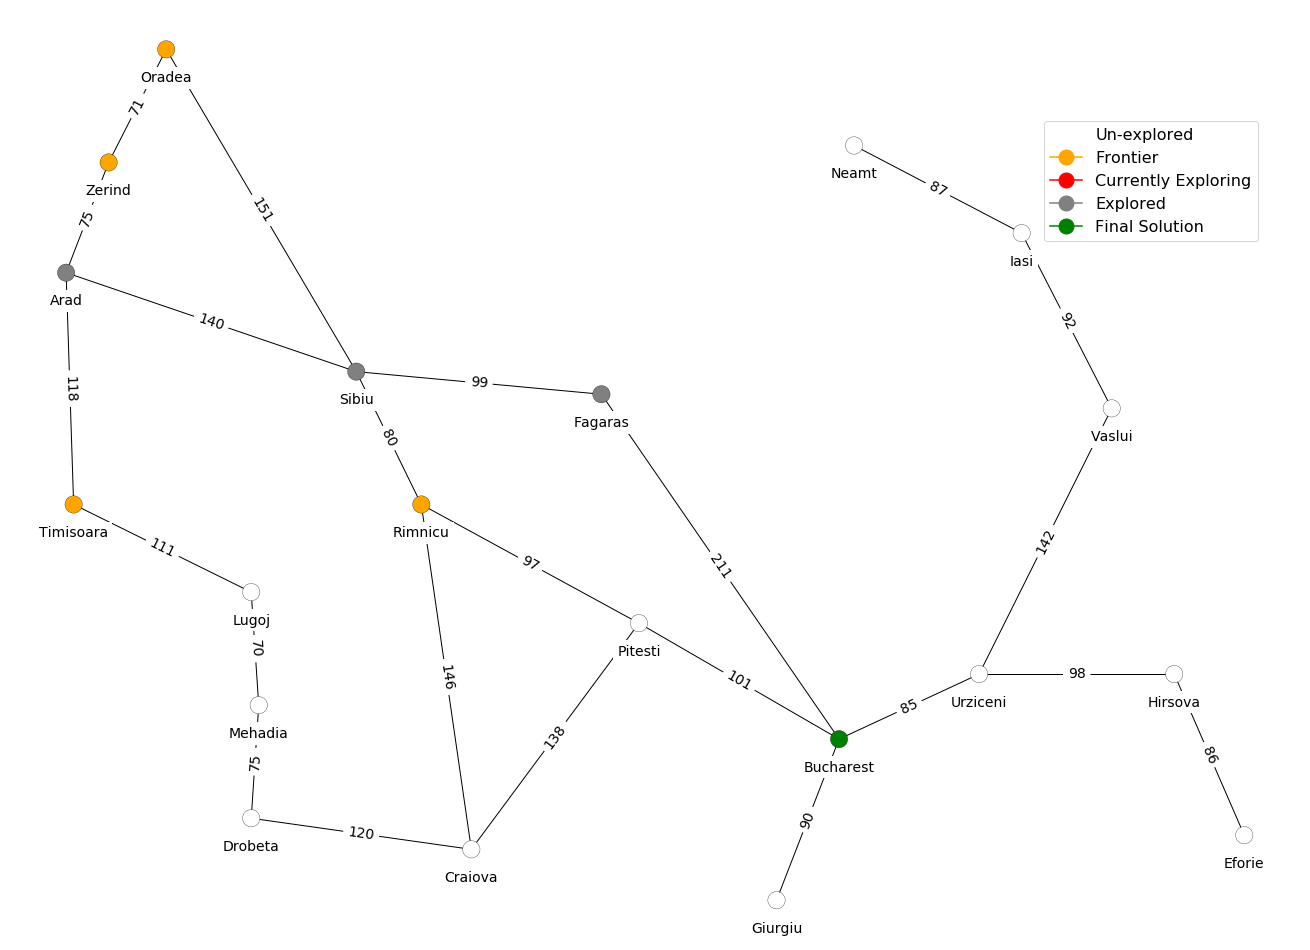

In [0]:
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)

iterations, current_node_colors, node = greedy_best_first_search(romania_problem)

new_romania_graph_data = {
    'graph_dict' : romania_map.graph_dict,
    'node_colors': current_node_colors,
    'node_positions': node_positions,
    'node_label_positions': node_label_pos,
     'edge_weights': edge_weights
}

show_map(new_romania_graph_data)

## Busca A*

Abaixo está a busca A* que visita primeiro as cidades que tem menor distância em linha reta do destino somada com o custo acumulado.

In [0]:
def astar_search_graph(problem, h=None):
    """A* search is best-first graph search with f(n) = g(n)+h(n).
    You need to specify the h function when you call astar_search, or
    else in your Problem subclass."""
    h = memoize(h or problem.h, 'h')
    
    def cost_fn(n):
        return n.path_cost + h(n)
    
    iterations, current_node_colors, node = best_first_graph_search_for_vis(problem, 
                                                                cost_fn)
    return(iterations, current_node_colors, node)

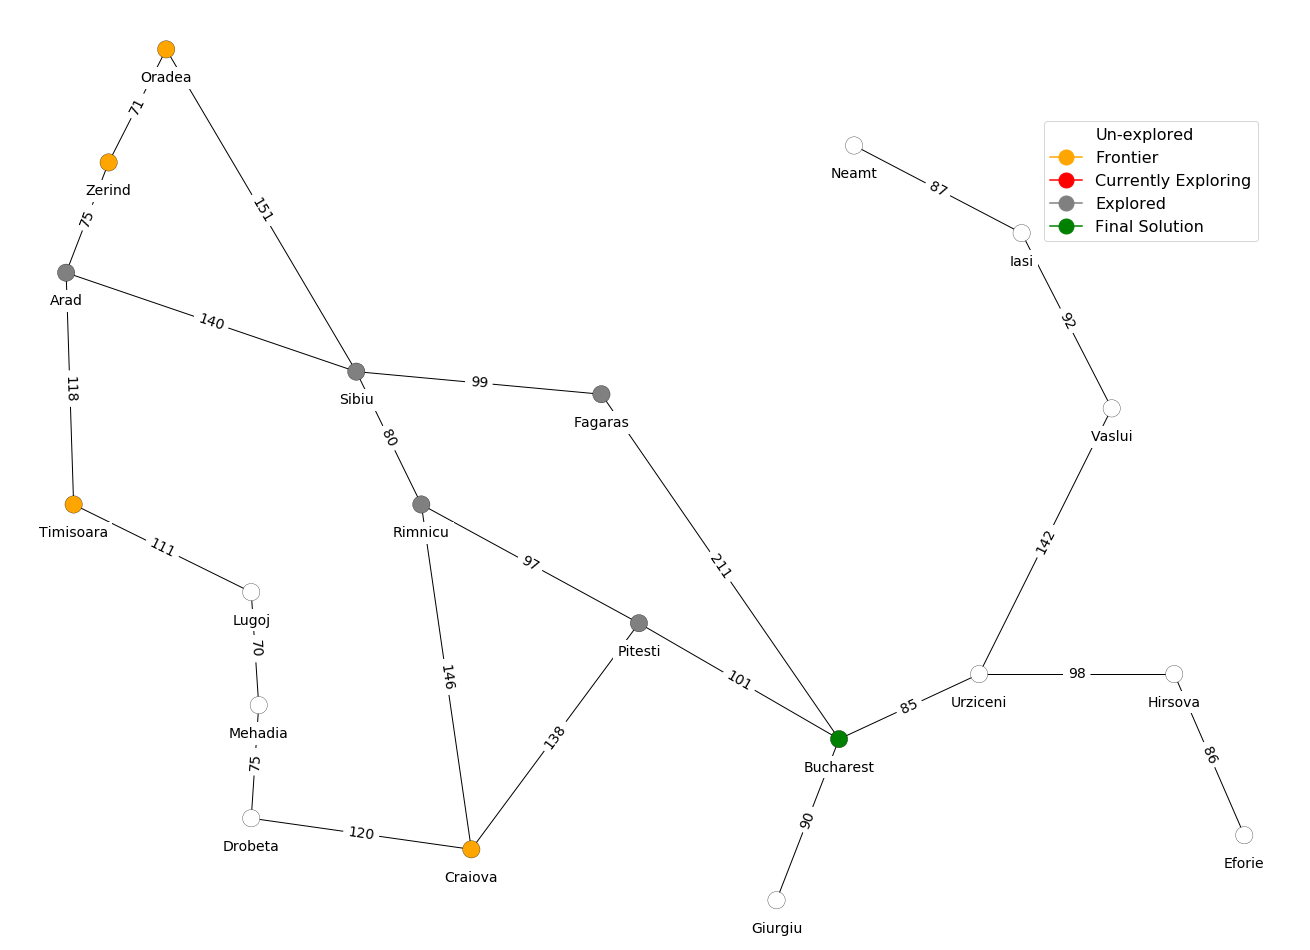

In [0]:
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)

iterations, current_node_colors, node = astar_search_graph(romania_problem)

new_romania_graph_data = {
    'graph_dict' : romania_map.graph_dict,
    'node_colors': current_node_colors,
    'node_positions': node_positions,
    'node_label_positions': node_label_pos,
     'edge_weights': edge_weights
}

show_map(new_romania_graph_data)

## Agora é sua vez

Da mesma forma que no exercício passado, para cada uma das duas abordagens de busca heurística, verifique o número de iterações e o tempo que o algoritmo demorou para executar. Para deixar sua análise mais interessante, faça 30 medições para cada par de cidades diferentes, ou seja, entre Arad e todas as outras cidades, entre Zerind e todas as outras cidades, etc.

Após medir o número de iterações e o tempo de execução de cada algoritmo, veja a média, mediana, desvio padrão para cada um dos algoritmos e responda: **Para este conjunto de dados, qual algoritmo é melhor?**

In [0]:
## Realize aqui sua comparação entre os algoritmos

##Teste Com Busca Gulosa

In [0]:
import numpy as np

elapsed_time_list_ar = []
iterations_ar = []

for city1 in romania_map.locations.keys():
    for city2 in romania_map.locations.keys():
        for x in range(0,30):
            start_time = time.time()
            current_node_colors = {}
            romania_problem = GraphProblem(city1, city2, romania_map)

            iterations, current_node_colors, node = greedy_best_first_search(romania_problem)

            new_romania_graph_data = {  'graph_dict' : romania_map.graph_dict,
                                    'node_colors': current_node_colors,
                                    'node_positions': node_positions,
                                    'node_label_positions': node_label_pos,
                                     'edge_weights': edge_weights
                                 }
            #show_map(new_romania_graph_data)
            elapsed_time = time.time() - start_time
            
            elapsed_time_list_ar.append(elapsed_time)
            
            iterations_ar.append(iterations)

iterationsMean = np.mean(elapsed_time_list_ar)
iterationsMedian = np.median(elapsed_time_list_ar)
iterationsStdDev = np.std(elapsed_time_list_ar)

elapsedTimeMean = np.mean(iterations_ar)
elapsedTimeMeadian = np.median(iterations_ar)
elapsedTimeStdDev = np.std(iterations_ar)

print("### Run Analysis Greedy Search ### \nElapsed Time Mean: {0}, Elapsed Time Median: {1}, Elapsed time StdDev: {2} \nIterations Mean: {3}, Iterations Median: {4}, Iterations StdDev: {5}"
      .format(iterationsMean, iterationsMedian, iterationsStdDev, elapsedTimeMean, elapsedTimeMeadian, elapsedTimeStdDev))
           

### Run Analysis Greedy Search ### 
Elapsed Time Mean: 0.00010082650184631347, Elapsed Time Median: 9.5367431640625e-05, Elapsed time StdDev: 5.117678721319659e-05 
Iterations Mean: 18.9025, Iterations Median: 18.0, Iterations StdDev: 8.599011207691266


##Teste com Busca A*

In [0]:
import numpy as np

elapsed_time_list_ar = []
iterations_ar = []

for city1 in romania_map.locations.keys():
    for city2 in romania_map.locations.keys():
        for x in range(0,30):
            start_time = time.time()
            current_node_colors = {}
            romania_problem = GraphProblem(city1, city2, romania_map)

            iterations, current_node_colors, node = astar_search_graph(romania_problem)

            new_romania_graph_data = {  'graph_dict' : romania_map.graph_dict,
                                    'node_colors': current_node_colors,
                                    'node_positions': node_positions,
                                    'node_label_positions': node_label_pos,
                                     'edge_weights': edge_weights
                                 }
            #show_map(new_romania_graph_data)
            elapsed_time = time.time() - start_time
            
            elapsed_time_list_ar.append(elapsed_time)
            
            iterations_ar.append(iterations)

iterationsMean = np.mean(elapsed_time_list_ar)
iterationsMedian = np.median(elapsed_time_list_ar)
iterationsStdDev = np.std(elapsed_time_list_ar)

elapsedTimeMean = np.mean(iterations_ar)
elapsedTimeMeadian = np.median(iterations_ar)
elapsedTimeStdDev = np.std(iterations_ar)



print("### Run Analysis A* Search ### \nElapsed Time Mean: {0}, Elapsed Time Median: {1}, Elapsed time StdDev: {2} \nIterations Mean: {3}, Iterations Median: {4}, Iterations StdDev: {5}"
      .format(iterationsMean, iterationsMedian, iterationsStdDev, elapsedTimeMean, elapsedTimeMeadian, elapsedTimeStdDev))

### Run Analysis A* Search ### 
Elapsed Time Mean: 0.0001310962239901225, Elapsed Time Median: 0.00011157989501953125, Elapsed time StdDev: 8.214862976918283e-05 
Iterations Mean: 23.7225, Iterations Median: 21.0, Iterations StdDev: 13.67334976331696


##Qual algoritmo é o melhor?

Neste caso, a Busca Gulosa se mostrou melhor, pois faz um menor número de iterações e desvio padrão menor do que o do algoritmo A*. 

Com relação ao tempo de execução, a Busca Gulosa também se mostrou superior executando em média o algoritmo mais rapidamente, apesar do desvio padrão ser um pouco superior ao da Busca Gulosa. No entanto, não considero essa diferença relevante para o problema atual já que ambos os valores são bem baixos.